In [38]:
import pandas as pd
import pandasql
import csv
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats
import numpy as np
import random

In [39]:
pathh='C:\\Users\\PC\\Desktop\\портфолио\\turnstile\\'   #Path to the file directory

weather_data = pd.read_csv(pathh+'weather_underground.csv')

In [40]:
"""
Programm 
1. Takes list of N names of the files (.csv), consisting data from subway turnstiles, give N updated files: update_filenames[i] (in .csv format)
In updated file there is only one data point for one row. (Data before update had several data point in one row).
2. Consolidating updated turnstile files in file master_turnstile.csv
3. Takes "REGULAR" information from master_turnstile.csv.
4. Adds column: difference between entries in this and previous record (Only between the same source of data).
If there is difference between two sources of data or NaN about exits and entries, puts 0 in ENTRIESn column.
5. TIMEn rows differ only by hours. It's reasonable to represent TIMEn column in hours to make data easier to analyse.
6. Date in weather file presented in YYYY-MM-DD format. To work with both we will format subway from DD-MM-YY to YYYY-MM-DD.
7. Makes statictic test of hours entries locally (for evry single turnstile) to accept of regect the normality of given data.
8. Makes statictic test for understending if the rain is really influence on daily entries.
9. Makes united dataframe for weather_data and master_turnstile.
10. Makes linear regression with gradient descent to predict hourly entries by rain, time and train/turnstile characteristics.
10a. Analyze how to replace text data (like UNIT, SCD, C/A, TIMEn) by numerous data.
10b. Upgrade Dataframe using new data
10c. Divide data on training points and 30 test points.
10d. Train model.
10e. Count R^2 and mean difference between test points and predicted (on test data) points.
"""

'\nProgramm \n1. Takes list of N names of the files (.csv), consisting data from subway turnstiles, give N updated files: update_filenames[i] (in .csv format)\nIn updated file there is only one data point for one row. (Data before update had several data point in one row).\n2. Consolidating updated turnstile files in file master_turnstile.csv\n3. Takes "REGULAR" information from master_turnstile.csv.\n4. Adds column: difference between entries in this and previous record (Only between the same source of data).\nIf there is difference between two sources of data or NaN about exits and entries, puts 0 in ENTRIESn column.\n5. TIMEn rows differ only by hours. It\'s reasonable to represent TIMEn column in hours to make data easier to analyse.\n6. Date in weather file presented in YYYY-MM-DD format. To work with both we will format subway from DD-MM-YY to YYYY-MM-DD.\n7. Makes statictic test of hours entries locally (for evry single turnstile) to accept of regect the normality of given data.

In [41]:
def txt_maker(filenames): #list of files names (with pathes)
    new_files=[]
    for i in range(len(filenames)):
        with open(filenames[i], newline='') as csvfile:
            text = csv.reader(csvfile, delimiter=' ')
            new_rows=[]
        
            for row in text:
                row[0] = row[0].split(',')
                begin=row[0][0:3]
                new_rows.append(row[0][:8])
            
                for i in range((len(row[0])-8)//5):
                    new_rows.append(begin+row[0][8+i*5:8+(i+1)*5])
            new_files.append(new_rows)
    return new_files

def strr(l):
    for i in range(len(l)):
        l[i]=str(l[i])
    return l

def summ(l):
    s=''
    for i in range(len(l)):
        s+=l[i]+','
    s=s[:-1]
    return s

def stringer(l):
    for i in range(len(l)):
        l[i] = summ(strr(l[i]))
    return l

def path(filenames:list, path:str):
    for i in range(len(filenames)):
        filenames[i] = path+filenames[i]
    return filenames

In [42]:
#saving updated data in format updated_filenames[i]

filenames = path(['turnstile_110507.csv', 'turnstile_110528.csv'], pathh)

for i in range(len(filenames)):
    with open(filenames[i][:len(pathh)]+"updated_"+filenames[i][len(pathh):], "w") as f:
        for j in stringer(txt_maker(filenames)[i]):
            f.write(j+'\n')

In [43]:
#2. consolidating updated turnstile files

with open(pathh+'master_turnstile.csv', 'w') as master_turnstile:
        master_turnstile.write('C/A,UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn\n')
        for filename in filenames:
            with open(filename[:len(pathh)]+"updated_"+filename[len(pathh):], 'r') as f:
                s = f.read()
                master_turnstile.write(s)

In [44]:
#3. Choose those where DESCn is REGULAR
turnstile_data = pd.read_csv(pathh+'master_turnstile.csv')
df = pd.DataFrame(turnstile_data)

In [45]:
#4.
def entries_difference(df):
    ENTRIESn_hourly=[]
    for i in range(len(df['EXITSn'])):
        try:
            if ( (df['C/A'][i] == df['C/A'][i-1]) & (df['UNIT'][i] == df['UNIT'][i-1]) & (df['SCP'][i] == df['SCP'][i-1]) ):    
                ENTRIESn_hourly.append(abs(df['ENTRIESn'][i]-df['ENTRIESn'][i-1]))     
            else:
                ENTRIESn_hourly.append(0)
        except:
            ENTRIESn_hourly.append(0)
    df['ENTRIESn_hourly'] = ENTRIESn_hourly 
    return df

In [46]:
df = entries_difference(df)

In [47]:
#5
def time_to_hour(time):
    try:
        hours = int(str(time)[1]) if str(time)[0] == '0' else int(str(time)[0:2])
        return hours
    except:
        pass

A=list(df['TIMEn'])
for i in range(len(A)):
    A[i]=time_to_hour(A[i])
df['TIMEn'] = A 

In [48]:
#6.
def reformat_subway_dates(date):
    date=date[:5]+'-20'+date[6:]
    date_formatted = datetime.datetime.strptime(date, "%m-%d-%Y").strftime("%Y-%m-%d")
    return date_formatted

A=list(df['DATEn'])
for i in range(len(A)):
    A[i]=reformat_subway_dates(A[i])
df['DATEn'] = A 

In [49]:
df.columns = ['C_A', 'UNIT','SCP','DATEn','TIMEn','DESCn','ENTRIESn','EXITSn', 'ENTRIESn_hourly']
df = df[df['DESCn'] == 'REGULAR']

In [50]:
df_weather_query="""
SELECT C_A, UNIT,SCP,DATEn,TIMEn,DESCn,ENTRIESn,EXITSn, ENTRIESn_hourly, rain
FROM df JOIN weather_data ON weather_data.date = df.DATEn
"""
df=pandasql.sqldf(df_weather_query.lower(), locals())

In [51]:
c_a="""
SELECT c_a, SUM(entriesn_hourly) AS c_a_entries
FROM df
GROUP BY c_a
"""
c_a_pre_dict=pandasql.sqldf(c_a.lower(), locals())

c_a_pre_dict['c_a_entries'] = c_a_pre_dict['c_a_entries']/c_a_pre_dict['c_a_entries'].max()
c_a_dict = {list(c_a_pre_dict['C_A'])[i] : list(c_a_pre_dict['c_a_entries'])[i] for i in range(len(c_a_pre_dict))}

unit = """
SELECT UNIT, SUM(entriesn_hourly) AS unit_entries
FROM df
GROUP BY UNIT
"""
unit_pre_dict=pandasql.sqldf(unit.lower(), locals())

unit_pre_dict['unit_entries'] = unit_pre_dict['unit_entries']/unit_pre_dict['unit_entries'].max()
unit_dict = {list(unit_pre_dict['UNIT'])[i] : list(unit_pre_dict['unit_entries'])[i] for i in range(len(unit_pre_dict))}

scp = """
SELECT SCP, SUM(entriesn_hourly) AS scp_entries
FROM df
GROUP BY SCP
"""
scp_pre_dict=pandasql.sqldf(scp.lower(), locals())

scp_pre_dict['scp_entries'] = scp_pre_dict['scp_entries']/scp_pre_dict['scp_entries'].max()
scp_dict = {list(scp_pre_dict['SCP'])[i] : list(scp_pre_dict['scp_entries'])[i] for i in range(len(scp_pre_dict))}

time_dict={0:153.726340514, 1:50, 2:120, 3:1, 4:20., 5:5, 6:13, 7:13, 8:16., 9:35, 10:58, 11:250, 12:87.1879611816, 13:72, 14:200, 15:130, 16:224.358640612, 17:220, 18:750, 19:300, 20:750, 21:350, 22:701, 23:25} #following the normal distribution

In [52]:
c_a_value=[]
unit_value=[]
scp_value=[]
time_value=[]

for c_a in df['C_A']:
    c_a_value.append(c_a_dict[c_a])
for unit in df['UNIT']:
    unit_value.append(unit_dict[unit])
for scp in df['SCP']:
    scp_value.append(scp_dict[scp])
for time in df['TIMEn']:
    time_value.append(time_dict[time])

df['c_a_value'] = c_a_value
df['unit_value'] = unit_value
df['scp_value'] = scp_value
df['time_value'] = time_value

df = df[['c_a_value', 'unit_value', 'scp_value', 'time_value', 'rain', 'ENTRIESn_hourly']]

In [53]:
#Statictics test
#In Shapiro test p-value shows the probability of hypotesis "data is normally distributed" being True 
#(another words: the probabylity of null hypotesis to be True)

print('Single turnstile p-value: ',scipy.stats.shapiro(df['ENTRIESn_hourly'][2:8])[1])

# Conclusion: 
# Hourly entries from day to day are normally distributed by hours. (according to Shapiro test)

Single turnstile p-value:  0.46715131402015686


In [54]:
events_frame=df

# Set a random seed so we will get the same results each time

random.seed(56)

# Randomly select 30 events for our test set
test_indices = set(random.sample(range(events_frame.shape[0]), 30))

# Split our data into training and test data
train_features = []
train_labels = []
test_features = []
test_labels = []

i = 0
for c_a_value, unit_value, scp_value, time_value, rain, ENTRIESn_hourly in events_frame.values:
    if i in test_indices:
        # Use starburst as our label, and all others as our features
        test_features.append([c_a_value, unit_value, scp_value, time_value, rain])
        test_labels.append(ENTRIESn_hourly)
    else:
        train_features.append([c_a_value, unit_value, scp_value, time_value, rain])
        train_labels.append(ENTRIESn_hourly)
    
    i += 1

In [55]:
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
model = linear_model.LinearRegression()
model.fit(train_features, train_labels)

LinearRegression()

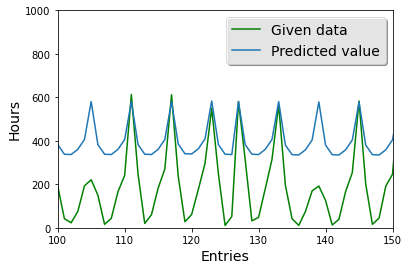

In [56]:
# Plot predicted and true interarrival times on the training set

plt.plot(train_labels, color="green", label="Given data")
plt.plot(model.predict(train_features), label="Predicted value")

plt.xlim(100, 150)
plt.ylim(0, 1000)
plt.xlabel("Entries", fontsize=14)
plt.ylabel("Hours", fontsize=14)
plt.legend(frameon=True, shadow=True, framealpha=0.7, loc=0, prop={"size": 14})

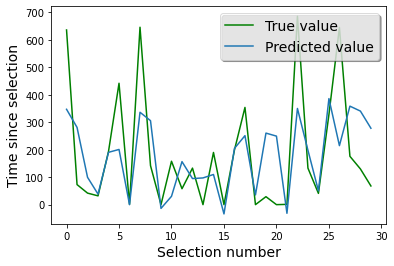

In [57]:
# Plot predicted and true time since selection on the test set 

plt.plot(test_labels, color="green", label="True value")
plt.plot(model.predict(test_features), label="Predicted value")

plt.xlabel("Selection number", fontsize=14)
plt.ylabel("Time since selection", fontsize=14)
plt.legend(frameon=True, shadow=True, framealpha=0.7, loc=0, prop={"size": 14})

In [58]:
# Print mean squared error and R^2 on the test set
print('mean difference =',np.mean((model.predict(test_features) - test_labels) ** 2))
print('R^2 =',model.score(test_features, test_labels))

mean difference = 30390.658346364693
R^2 = 0.33697900494201316
